# Creating the Bathymetry

I will create the underlying bathymetry grid used in my model of Ha Long Bay and the surrounding Tonkin Gulf.

First, import packages to re-create and visualize the model grid here:

In [1]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import netCDF4 as nc4

### Bathymetry Source File
To generate the bathymetry for the model, first obtain a subset of the global GEBCO bathymetry grid from here: https://download.gebco.net/

For my model, I took a subset covering the grid from $18.5^{\circ}-21.5^{\circ}N$, $106.0^{\circ}-110.0^{\circ}E$ in the Tonkin Gulf region. I saved this file as `GEBCO_TG.nc`.

### Interpolating Bathymetry onto the Model Domain
Next, I use an interpolation function to interpolate the GEBCO Bathymetry onto the domain of my model.

In [2]:
# read in the bathymetry grid
file_path = 'C:\\Users\\azure\\Documents\\CS185C\\project\\data\\GEBCO\\GEBCO_TG.nc'
ds = nc4.Dataset(file_path)
gebco_lon = ds.variables['lon'][:]
gebco_lat = ds.variables['lat'][:]
Gebco_bathy = ds.variables['elevation'][:]
ds.close()

# create a meshgrid of the lon and lat
Gebco_Lon, Gebco_Lat = np.meshgrid(gebco_lon, gebco_lat)

In [3]:
# recreate the model grid - see previous notebook on creating the model grid for details
delX = 1/40
delY = 1/40
xgOrigin = 106.0
ygOrigin = 18.5
n_rows = 121
n_cols = 161

xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY, delY)
XC, YC = np.meshgrid(xc, yc)
print('Double check shape:', np.shape(xc),np.shape(yc))

Double check shape: (161,) (121,)


In [4]:
# interpolate the gebco data onto the model grid
Model_bathy = griddata(np.column_stack([Gebco_Lon.ravel(),Gebco_Lat.ravel()]), Gebco_bathy.ravel(), (XC, YC), method='nearest')

In [5]:
# set points on land to 0
Model_bathy[Model_bathy>0] = 0

### Visualizing the Bathymetry Grid
Finally, I create a plot of the bathymetry and compare with the source data to ensure everything turns out as expected:

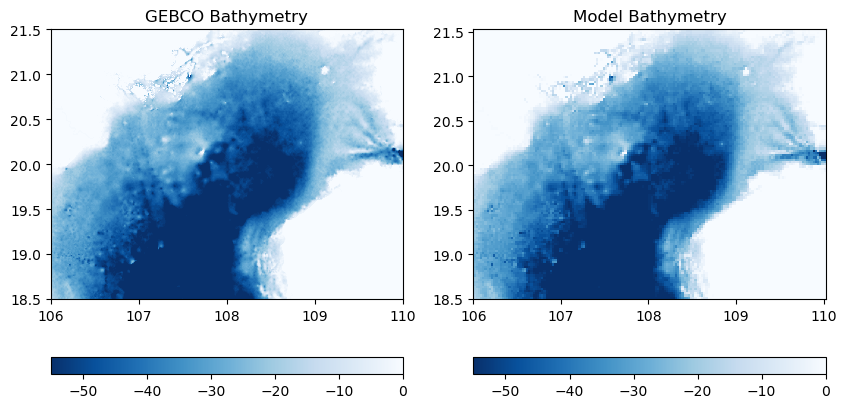

In [6]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(Gebco_Lon, Gebco_Lat, Gebco_bathy, vmin=-55, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('GEBCO Bathymetry')

plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, Model_bathy, vmin=-55, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

plt.show()

This will be implemented into the model by editing the `PARM05` dataset of the `data` file as follows:
```
 &PARM05
 bathyFile = 'TG_bathymetry.bin,
 &
```

I will also run a command that converts the data file I received from the GEBCO website, `GEBCO_TG.nc`, to a `.bin` file that the MITgcm is able to read and use.


In [7]:
output_file = 'TG_bathymetry.bin'
Model_bathy.ravel('C').astype('>f4').tofile(output_file)